## Bivariate Granger Causality

This notebook is based on the bivariate Granger causality example provided in the journal paper,

McGraw, M.C. and E.A. Barnes, 2018: **Memory Matters: A Case for Granger Causality in Climate Variability Studies**. J. Climate, 31, 3289–3300, https://doi.org/10.1175/JCLI-D-17-0334.1

**Granger causality in a nutshell:**

* Granger causality is based on the predictability of temporal variables. A time series $X = \{{x_t}\}_{t=1}^{T}$ is said to be a Granger cause of $Y = \{{y_t}\}_{t=1}^{T}$, if the past values of $X$  provide information about the current state of $Y,$ beyond what is already known from the past values of $Y,$ alone. 


* To determine Granger causality, we compare two prediction models:
    - **Restricted model:** A model where $Y$ is predicted using only the past values of $Y$. 
    - **Unrestricted model:** A model where $Y$ is predicted using the past values of both $X$ and $Y.$ 
    

* Then a statistical test is carried out to determine whether the unrestricted model significantly improves the predictability of $Y$ compared to the restricted model.  If the predictability of $Y$ is significantly improved by the inclusion of $X$ in the model, $X$ is said to Granger cause $Y$.

In this notebook, we generate sample data based on the paper by McGraw and Barnes (2018) and apply the bivariate Granger causality test to identify potential cause-effect relationships.

This notebook was created by Savini M. Samarasinghe of Colorado State University with the suggestions from Marie C. McGraw of the University of Washington. This is part of the Data Analysis Tools for Atmospheric Scientists ([DATAS](https://datasgateway.colostate.edu/)) Gateway. November 2019. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm 

### Generate Sample Data

As the first step we generate sample data of two variables, a driver $D$ and a response $R$ that are based on the equations below.

\begin{equation}
D(t) = \alpha D(t-1) + {(1 - \alpha^2)}^{1/2}\epsilon_D(t)
\end{equation}
\begin{equation}
R(t) = D(t-\tau)+ \gamma \epsilon_R(t)
\end{equation}

As stated in the paper, $\alpha$ is the lag-1 autocorrelation and $\epsilon_D$ is a random value drawn from a standard normal distribution. The driving variable $D$ has a variance of one. The response variable $R$ is created by lagging $D$ by some amount of time $\tau >0$, with added Gaussian noise $\epsilon_R$. The parameter $\gamma$ controls the amount of additional noise added to $R$. We call the `generate_sample_data` function below with suitable parameters to generate sample data.

In [2]:
def generate_sample_data(alpha, tau, gamma, num_samples, num_drop):

    """Generates D and R time series based on the given equations.
    num_samples: number of samples in the generated time series
    num_drop: number of samples dropped from the generated series to address initialization
    
    returns D and R time series each consisting (num_samples - num_drop) many samples
    """

    assert num_drop < num_samples, 'Error: num_samples has to be greater than num_drop'
    
    # initialize the variables
    d = np.empty(num_samples)
    r = np.empty(num_samples)

    e_d = np.random.normal(0,1,num_samples) # random values drawn from a standard normal distribution  
    e_r = np.random.normal(0,1,num_samples)

    # generate data
    d[0] = e_d[0]
    for i in range(1,num_samples):
        d[i] = alpha*d[i-1] + np.sqrt((1-alpha**2))*e_d[i]

    r[:tau] = e_r[:tau]
    for i in range(tau,num_samples):
        r[i] = d[i-tau] + gamma*e_r[i]

    return [d[num_drop:],r[num_drop:]] # drop first few samples

### Bivariate Granger Causality Test

As mentioned before, we need to compare two prediction models - a restricted vs. an unrestricted model to identify a Granger cause. For the prediction model, a suitable linear or nonlinear model can be used. In this notebook, we use lagged linear regression models resulting in two models as follows,
 
\begin{equation}
\mbox{Restricted model:} \quad y_t = \gamma + b_1 y_{t-1} + b_2 y_{t-2}+ \ldots + b_s y_{t-s} + e_r
\label{restricted_eq} 
\end{equation}
\begin{equation}
\mbox{Unrestricted model:} \quad y_t = \beta + a_1 y_{t-1} + a_2 y_{t-2}+ \ldots + a_s y_{t-s} + c_1 x_{t-1} + c_2 x_{t-2}+ \ldots + c_p x_{t-p} + e_u
\label{unrestricted_eq} 
\end{equation}

Here $a_i$, $b_i$ (for integer $i \in [1,s] $) and $c_j$ (for integer $j \in [1,p]$) are scalar regression coefficients and $\beta$ and $\gamma$ are model intercepts. 
$s$ is the maximum lag of $Y$ and $p$ is the maximum lag of $X$ used for prediction. $e_r$ and $e_u$ are the error terms of the restricted and unrestricted models respectively. **For simplicity, we use the same number of lags for each variable, i.e., $s=p$.**

To identify the suitable number of lags, we can use information criteria such as AIC or BIC or use an appropriate cross-validation scheme. The `bivariate_granger_casuality` function below creates restricted and unrestricted linear lagged regression models by finding the Ordinary Least Squares (OLS) solutions and compares them statistically using an F-test.

In [3]:
def bivariate_granger_causality(var_y, var_x, q, significance_level, standardize_data = True, verbose = True):
  
    """ 
    Tests whether var_x (X) Granger causes var_y (Y)
    
    Steps:
    (1) Creates restricted and unrestricted regression models. 
    (2) Checks whether X significantly improves the predictability of Y using an F test.
  
    q: number of maximum lags
    significance_level: alpha value for statistical testing
    verbose: set to True to print intermediate results

    User has the option to standardize the data. """
    
    
    def standardize_data(data):

        """Standardizes each column of the data matrix"""

        means = data.mean(axis=0)
        stds = data.std(axis=0)

        return (data - means) / stds 

    def create_restricted_unrestricted_models():
        
        """
        Restricted model: predicts Y using the past of Y
        Unrestricted model: predicts Y using the past of Y and X
        """
        
        time_series_len = len(var_y)
        restricted_model_predictors = np.empty((time_series_len-q,q))
        unrestricted_model_predictors = np.empty((time_series_len-q,q*2))

        # lagged predictors of the restricted model
        for i in range(q):
            restricted_model_predictors[:,q-i-1] = var_y.shift(-i)[:-q]

        # lagged predictors of the unrestricted model    
        for i in range(q):
            unrestricted_model_predictors[:,q-i-1] = var_y.shift(-i)[:-q]
            unrestricted_model_predictors[:,2*q-i-1] = var_x.shift(-i)[:-q]

        predictand = var_y.shift(-q)[:-q][:,np.newaxis] # variable to be predicted

        if(standardize_data):
            restricted_model_predictors = standardize_data(restricted_model_predictors)
            unrestricted_model_predictors = standardize_data(unrestricted_model_predictors)
            predictand = standardize_data(predictand)
    
        # stack a column of ones to calculate model intercept
        restricted_model_predictors = np.hstack((np.ones((time_series_len-q,1)),restricted_model_predictors)) 
        unrestricted_model_predictors = np.hstack((np.ones((time_series_len-q,1)),unrestricted_model_predictors))

        # fit the restricted and unrestricted linear regression models using ordinary least squares approach
        reg_restricted =  sm.OLS(predictand,restricted_model_predictors).fit()
        reg_unrestricted = sm.OLS(predictand,unrestricted_model_predictors).fit()
        
        if(verbose):
            print('Testing for bivariate Granger causality.')
            print('Restricted Model:')
            print('p-value of the F-test for a joint linear hypothesis = {}'.format(reg_restricted.f_pvalue))
            print('R squared value of the model = {}'.format(reg_restricted.rsquared))
            
            print('--------------------------------------------------------------------------------------------')
            print('Unrestricted Model:')
            print('p-value of the F-test for a joint linear hypothesis = {}'.format(reg_unrestricted.f_pvalue))
            print('R squared value of the model = {}'.format(reg_unrestricted.rsquared))
            

        
        return reg_restricted, reg_unrestricted, predictand, restricted_model_predictors, unrestricted_model_predictors
        
    def evaluate_F_test_on_null_hypothesis(reg_restricted, reg_unrestricted, predictand, restricted_model_predictors, 
    unrestricted_model_predictors, significance_level):
        
        """Compares the sum of squares of residuals of the unrestricted model with the restricted model using an F test"""
        
        # residuals of the restricted and unrestricted models        
        restricted_model_residuals = predictand - reg_restricted.predict(restricted_model_predictors)[:,np.newaxis]
        unrestricted_model_residuals = predictand  - reg_unrestricted.predict(unrestricted_model_predictors)[:,np.newaxis]
        
        time_series_len = len(predictand)
        # degrees of freedom
        df_num = max_lags 
        df_den = (time_series_len - 2*max_lags - 1)
        
        F_num = (np.nansum(restricted_model_residuals**2) - np.nansum(unrestricted_model_residuals**2))/df_num
        F_den = np.nansum(unrestricted_model_residuals**2)/df_den
                
        test_stat = F_num/F_den # test statistic
        F_crit = stats.f.ppf(q=1-significance_level, dfn=df_num, dfd=df_den) # critical value
            
        if(test_stat>F_crit):
            granger_cause = 1
            if(verbose):
                print('--------------------------------------------------------------------------------------------')      
                print('F test: Test statistic = {}, Critical value = {}'.format(test_stat,F_crit))
                print('Reject null hypothesis.')
        else:
            granger_cause = 0
            if(verbose):
                print('--------------------------------------------------------------------------------------------')      
                print('F test: Test statistic = {}, Critical value = {}'.format(test_stat,F_crit))  
                print('Fail to reject null hypothesis.')  
        return granger_cause
            
    reg_restricted, reg_unrestricted, predictand, restricted_model_predictors,unrestricted_model_predictors = create_restricted_unrestricted_models()
    granger_cause = evaluate_F_test_on_null_hypothesis(reg_restricted, reg_unrestricted, predictand, 
                                                       restricted_model_predictors,unrestricted_model_predictors, 
                                                       significance_level)
           
    return granger_cause, reg_unrestricted

### Statistical Test

We use a statistical test to determine whether the unrestricted model significantly improves the predictability of $Y$ compared to the restricted model.

\begin{equation}
\mbox{Restricted model:} \quad y_t = \gamma + b_1 y_{t-1} + b_2 y_{t-2}+ \ldots + b_s y_{t-s} + e_r 
\end{equation}
\begin{equation}
\mbox{Unrestricted model:} \quad y_t = \beta + a_1 y_{t-1} + a_2 y_{t-2}+ \ldots + a_s y_{t-s} + c_1 x_{t-1} + c_2 x_{t-2}+ \ldots + c_p x_{t-p} + e_u
\end{equation}

$X$ is not a Granger cause of $Y$ if all the regression coefficients related to $X$, i.e., $c_1,\ldots,c_p$, are equal to zero. In other words, this is when $X$ does not significantly contribute to the predictability of $Y$.

Thus the null-hypothesis for non-causality is $H_0:c_1 = c_2 = \ldots = c_p = 0$

To test this null-hypothesis we calculate the following test statistic (Attanasio, A, 2012),

\begin{equation}
\mbox{Test statistic} = \large{\frac{\frac{RSS_{r} - RSS_{u}}{q}}{\frac{RSS_{u}}{T-m}}}
\end{equation}

where 
* $RSS_{r}$ and $RSS_{u}$ are the residual sum of squares of the restricted and unrestricted models respectively.
* $q$: number of coefficients restricted to zero, i.e., $q = p$.
* $T$: number of observations.
* $m$: number of coefficients in the unrestricted model, i.e., $m = p+s+1$. (Note that $s=p$ in our implementation.)


Under the assumption that the time series are stationary, the test statistics asymptotically
has a $F(q, T − m)$ distribution under $H_0$.
If the test statistic is greater than a specified critical value, i.e., when there is a significant statistic, the null hypothesis of noncausality is rejected (Attanasio, A, 2012).





### Example

Based on the equations for D and R, we expect the following relationships to hold,
* D Granger causes R.
* R does not Granger cause D.

Now we check whether the bivariate Granger causality test can identify these relationships correctly. In this example, we use a statistical significance level of 0.05.

In [4]:
[D,R] = generate_sample_data(alpha = 0.7, tau = 1, gamma = 0.3, num_samples = 550, num_drop = 50)

In [5]:
max_lags = 3 # maximum number of lags
significance_level = 0.05 # alpha value for statistical testing
standardize_data = True
verbose = True # set to True to print intermediate results

**First we check whether D causes R.**

In [6]:
granger_cause_DR, reg_unrestricted_DR =bivariate_granger_causality(var_y = pd.Series(R),var_x = pd.Series(D),q = max_lags, 
                                       significance_level = significance_level, standardize_data = standardize_data, 
                                                                   verbose = verbose) # does D cause R?

Testing for bivariate Granger causality.
Restricted Model:
p-value of the F-test for a joint linear hypothesis = 5.6546381117992205e-40
R squared value of the model = 0.31336176024386886
--------------------------------------------------------------------------------------------
Unrestricted Model:
p-value of the F-test for a joint linear hypothesis = 5.300648309370372e-254
R squared value of the model = 0.9112325857405571
--------------------------------------------------------------------------------------------
F test: Test statistic = 1100.0910147693946, Critical value = 2.6231001100089393
Reject null hypothesis.


We reject the null in favor of the alternative hypothesis, which states that D Granger causes R.

**Now we check whether R causes D.**

In [7]:
granger_cause_RD, reg_unrestricted_RD = bivariate_granger_causality(var_y = pd.Series(D),var_x = pd.Series(R),q = max_lags, 
                                        significance_level = significance_level, standardize_data = standardize_data, 
                                                                    verbose = verbose) # does R cause D?

Testing for bivariate Granger causality.
Restricted Model:
p-value of the F-test for a joint linear hypothesis = 2.2235013556552917e-57
R squared value of the model = 0.4167300123503288
--------------------------------------------------------------------------------------------
Unrestricted Model:
p-value of the F-test for a joint linear hypothesis = 4.816647925031111e-56
R squared value of the model = 0.4259828049202369
--------------------------------------------------------------------------------------------
F test: Test statistic = 2.63282958426879, Critical value = 2.6231001100089393
Reject null hypothesis.


We fail to reject the null hypothesis.

The above tests suggest that D is a Granger cause of R as expected. Now we can look at the unrestricted model predicting R to identify predictors with statistically significant regression coefficients. Below is a summary of the unrestricted model predicting $R$ with $\mbox{max_lags} = 3$ where, 
* $x1, x2,x3$  are lagged variables of $R$.
* $x4, x5, x6$ are lagged variables of $D$.

In [8]:
print(reg_unrestricted_DR.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     838.3
Date:                Mon, 11 Nov 2019   Prob (F-statistic):          5.30e-254
Time:                        16:04:22   Log-Likelihood:                -103.41
No. Observations:                 497   AIC:                             220.8
Df Residuals:                     490   BIC:                             250.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.296e-17      0.013   2.45e-15      1.0

### Monte Carlo Simulations for different $\alpha$ and $\gamma$ values

In this section, we look at the Granger causality results for different $\alpha$ and $\gamma$ parameters. We also use a Monte Carlo simulation to account for the randomization of noise variables in the `generate_sample_data` function.

McGraw and Barnes (2018) show the utility of the Granger causality approach compared to simple lagged regression when dealing with variables that have high memory. The journal paper compares the results of the Granger causality approach with simple lagged regression, which is a more commonly used method in atmospheric sciences. See journal paper for comparisons and detailed interpretations of results.

In [9]:
num_monte_carlo = 100 # number of simulations
num_steps = 20
alpha = np.linspace(0,0.95,num_steps) 
gamma = np.linspace(0.005,10,num_steps) 
max_lags = 3 # maximum number of lags
significance_level = 0.05 # alpha value for statistical testing
standardize_data = True
verbose = False # set to True to see the intermediate steps printed out

In [10]:
causality_map_DR = np.zeros((len(alpha),len(gamma)))
causality_map_RD = np.zeros((len(alpha),len(gamma)))

for i in range(len(alpha)):
    for j in range(len(gamma)):
        
        granger_cause_RD_overall = 0
        granger_cause_DR_overall = 0
        
        for simulation in range(num_monte_carlo):
            [D,R] = generate_sample_data(alpha = alpha[i], tau = 1, gamma = gamma[j], num_samples = 550, num_drop = 50)
            
            try:
                # does R cause D?
                granger_cause_RD, reg_unrestricted_RD = bivariate_granger_causality(var_y = pd.Series(D),
                                                    var_x = pd.Series(R),q = max_lags, 
                                                    significance_level = significance_level,
                                                    standardize_data = standardize_data, verbose = verbose) 
                if(granger_cause_RD == 1):
                    granger_cause_RD_overall += granger_cause_RD

                # does D cause R?
                granger_cause_DR, reg_unrestricted_DR =bivariate_granger_causality(var_y = pd.Series(R),
                                                    var_x = pd.Series(D),q = max_lags, 
                                                    significance_level = significance_level, 
                                                    standardize_data = standardize_data, verbose = verbose) 
                if(granger_cause_DR == 1):
                    granger_cause_DR_overall += granger_cause_DR
            except:
                print("An exception occurred at alpha {} and gamma {}".format(alpha[i],gamma[j]))
            
        causality_map_DR[i,j] = np.copy(granger_cause_DR_overall)
        causality_map_RD[i,j] = np.copy(granger_cause_RD_overall)


In [11]:
def visualize_monte_carlo_results(gamma, alpha, causality_map,num_monte_carlo):
    
    fig = plt.figure(figsize=(6,5))
    gamma_grid, alpha_grid = np.meshgrid(gamma, alpha)
    cp = plt.pcolor(gamma_grid, alpha_grid, causality_map*100/num_monte_carlo, cmap='pink_r')
    plt.xlabel('gamma')
    plt.ylabel('alpha')
    cbar = plt.colorbar(cp)
    cbar.ax.set_ylabel('%')
    plt.clim((0,100))
    plt.show()

**First we check whether D causes R.**

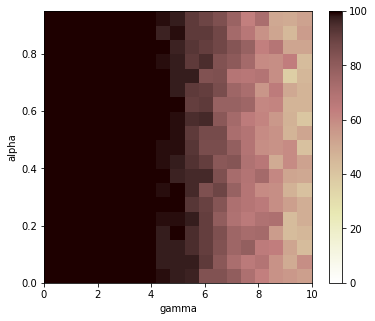

In [12]:
visualize_monte_carlo_results(gamma, alpha, causality_map_DR,num_monte_carlo)

The visualization shows the percentage of simulations giving statistically significant results for the Granger causality test at 95% confidence. We see that the true positive rate reduces as the data becomes noisier.

**Now we check whether R causes D.**

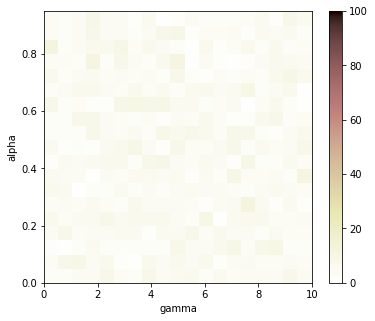

In [13]:
visualize_monte_carlo_results(gamma, alpha, causality_map_RD,num_monte_carlo)

There are some false positives, but the rate is low.

### Final Remarks

* It should be noted that we can only identify 'potential' cause-effect relationships using the Granger causality approach. This method may identify spurious relationships in the presence of hidden common causes. A variable Z that has not been included in the study is called a hidden common cause if it causes both X and Y.

* Even though not explained in this notebook, it is encouraged to do out-of-sample testing to mitigate problems related to overfitting to training data. Attanasio, A, 2012, discusses how to do out-of-sample testing as well as how to do statistical testing for non-stationary data. 

* As mentioned before, the restricted and unrestricted models can be created using appropriate nonlinear methods. This will allow us to identify both linear and nonlinear Granger causes. See Papagiannopoulou et. al., 2017,  for example.

### References
Attanasio, A., Testing for linear Granger causality from natural/anthropogenic forcings to global temperature anomalies, Theor Appl Climatol (2012) 110: 281. https://doi.org/10.1007/s00704-012-0634-x

McGraw, M.C. and E.A. Barnes, Memory Matters: A Case for Granger Causality in Climate Variability Studies. J. Climate (2018), 31, 3289–3300, https://doi.org/10.1175/JCLI-D-17-0334.1

Papagiannopoulou, C., Miralles, D. G., Decubber, S., Demuzere, M., Verhoest, N. E. C., Dorigo, W. A., and Waegeman, W.: A non-linear Granger-causality framework to investigate climate–vegetation dynamics, Geosci. Model Dev., 10, 1945–1960, https://doi.org/10.5194/gmd-10-1945-2017, 2017.
